**Особенность данного блокнота в том, что в качестве входных данных использовался не обычный датасет ISIC**, а сгенерированный на его основе путем использования техники "Style transfer" и датасета PAD-UFES-20 (датасет с изображениями деффектов кожи сделанных не на дерматоскоп, а на смартфон).

In [1]:
import pandas as pd
import numpy as np
from glob import glob

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
model = fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)
model.classifier.append(nn.Conv2d(21,1,1,1))
model.aux_classifier.append(nn.Conv2d(21,1,1,1))

FCNHead(
  (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(21, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [4]:
model = model.to(device)

In [5]:
inputs_path = "./inputs"
outputs_path = "./outputs"

In [66]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.Grayscale()])

In [67]:
class HAMImageDataset(Dataset):
    def __init__(self, train_path, labels_path, transform=None, target_transform=None):
        self.images = [path for path in glob(train_path + "/*.jpg")]
        self.labels = [path for path in glob(labels_path + "/*.png")]
        
        if len(self.images) != len(self.labels):
            print(len(self.images), len(self.labels))
            raise ValueError
        
        self.transform = transform
        self.target_transform = target_transform
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = read_image(self.images[idx])
        if image.shape[0] == 4:
            image = image[:3, :, :]
        label = read_image(self.labels[idx])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        label = label / 255.0
        
        return image, label.round()

In [78]:
# ds = HAMImageDataset(inputs_path, outputs_path, transform=transform, target_transform=transform)
x, y = ds[3]

torch.Size([1, 224, 224])


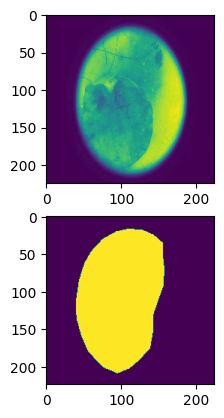

In [79]:
plt.subplot(2,1,1)
plt.imshow(np.transpose(x, (1,2,0)))
print(y.shape)
plt.subplot(2,1,2)
plt.imshow(np.transpose(y, (1,2,0)))
plt.show()

In [10]:
train_dataloader = DataLoader(ds, batch_size=16, shuffle=True)

In [11]:
#  fidelity metrics
def accuracy(pred, mask):
    """побитовая точность"""
    pred = pred.view(pred.size(0), -1)
    mask = mask.view(mask.size(0), -1)
    
    positives = (pred == mask).sum()
    N = pred.size(0) * pred.size(1)
    return positives / N 

In [12]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_acc = 0
    
    for i, batch in enumerate(loader):
        inputs, masks = batch
        inputs = inputs.float().to(device)
        masks = masks.float().to(device)
        
        
        outputs = model(inputs)["out"]
        
#         outputs = torch.nn.functional.softmax(outputs)
        
        flat_out = outputs
        flat_masks = masks
        
        loss = criterion(flat_out, flat_masks)
        
        total_acc = accuracy(torch.nn.functional.sigmoid(flat_out).round(), flat_masks).item()
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        
        if (i + 1) % 10 == 0:
            print("-" * 90)
            print("| loss:", (total_loss / (i + 1)), "| acc:", total_acc, "| iter: [" + str((i + 1)) + "/" \
                  + str(len(loader)) + "]|")
    return total_loss

In [216]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCEWithLogitsLoss()
epochs = 10
min_loss = np.inf
for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch} training...")
    loss = train(model, train_dataloader, optimizer, criterion)
    print("train loss:", loss / len(train_dataloader))
    if loss < min_loss:
        min_loss = loss
        print("BEST ATTEMT:", min_loss)
        torch.save(model.state_dict(), "fcn_resnet50-segmentation.pt")
    print("-" * 90)

Starting epoch 1 training...
------------------------------------------------------------------------------------------
| loss: 0.08088127747178078 | acc: 0.9719200730323792 | iter: [10/163]|
------------------------------------------------------------------------------------------
| loss: 0.07853913810104132 | acc: 0.9667943716049194 | iter: [20/163]|
------------------------------------------------------------------------------------------
| loss: 0.08011282371977965 | acc: 0.982014536857605 | iter: [30/163]|
------------------------------------------------------------------------------------------
| loss: 0.08073000060394406 | acc: 0.9715476036071777 | iter: [40/163]|
------------------------------------------------------------------------------------------
| loss: 0.07931000545620918 | acc: 0.981843888759613 | iter: [50/163]|
------------------------------------------------------------------------------------------
| loss: 0.07947435018916925 | acc: 0.9853677153587341 | iter: [60/1

train loss: 0.06400814103933931
BEST ATTEMT: 10.433326989412308
------------------------------------------------------------------------------------------
Starting epoch 4 training...
------------------------------------------------------------------------------------------
| loss: 0.05946665219962597 | acc: 0.9831505417823792 | iter: [10/163]|
------------------------------------------------------------------------------------------
| loss: 0.058528033457696436 | acc: 0.98529052734375 | iter: [20/163]|
------------------------------------------------------------------------------------------
| loss: 0.059338764970501265 | acc: 0.9828665256500244 | iter: [30/163]|
------------------------------------------------------------------------------------------
| loss: 0.06046886872500181 | acc: 0.9760617613792419 | iter: [40/163]|
------------------------------------------------------------------------------------------
| loss: 0.059827424809336664 | acc: 0.9677597284317017 | iter: [50/163]|


------------------------------------------------------------------------------------------
| loss: 0.05520579300355166 | acc: 0.9784919619560242 | iter: [160/163]|
train loss: 0.055723381851531244
BEST ATTEMT: 9.082911241799593
------------------------------------------------------------------------------------------
Starting epoch 7 training...
------------------------------------------------------------------------------------------
| loss: 0.05513289198279381 | acc: 0.9696679711341858 | iter: [10/163]|
------------------------------------------------------------------------------------------
| loss: 0.056421312317252156 | acc: 0.9817517399787903 | iter: [20/163]|
------------------------------------------------------------------------------------------
| loss: 0.054796279842654866 | acc: 0.9799044728279114 | iter: [30/163]|
------------------------------------------------------------------------------------------
| loss: 0.05511493440717459 | acc: 0.9797861576080322 | iter: [40/163]

------------------------------------------------------------------------------------------
| loss: 0.04945786419014136 | acc: 0.979605495929718 | iter: [150/163]|
------------------------------------------------------------------------------------------
| loss: 0.049391323956660925 | acc: 0.9871165752410889 | iter: [160/163]|
train loss: 0.049552374090885094
BEST ATTEMT: 8.07703697681427
------------------------------------------------------------------------------------------
Starting epoch 10 training...
------------------------------------------------------------------------------------------
| loss: 0.04713210761547089 | acc: 0.9760081768035889 | iter: [10/163]|
------------------------------------------------------------------------------------------
| loss: 0.04517299309372902 | acc: 0.9858061671257019 | iter: [20/163]|
------------------------------------------------------------------------------------------
| loss: 0.044787534947196644 | acc: 0.9797300696372986 | iter: [30/163]

In [13]:
model.load_state_dict(torch.load("fcn_resnet50-segmentation.pt"))

<All keys matched successfully>

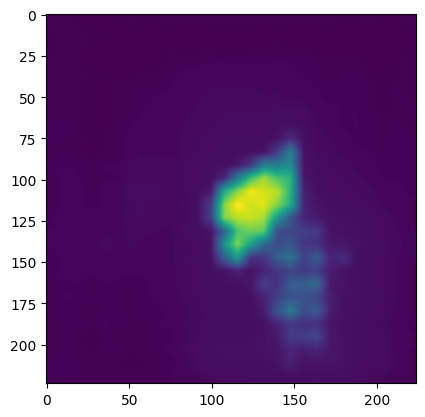

In [87]:
test = read_image("cluster.png")
test = test[:3, :, :]
test = transforms.Resize((224,224))(test)
res = model(test.float().unsqueeze(0).to(device))["out"]
res = res.squeeze(0).squeeze(0).round()
# res = torch.nn.functional.sigmoid(res)
plt.imshow(res.cpu().detach().numpy().round())

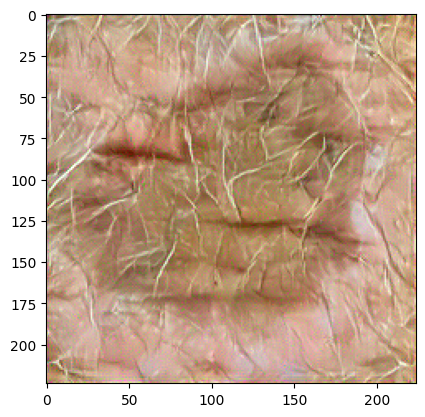

In [32]:
image2 = read_image("raw1.png")
image2 = transforms.Resize((224,224))(image2)
res = res.round()
# image2[3, :, :] = res
image2 = image2.numpy()
plt.imshow(np.transpose(image2, (1, 2, 0)))

In [33]:
image3 = image2[1, :, :]
image3.shape

(224, 224)

In [123]:
image2.shape

(4, 224, 224)

In [34]:
mask = read_image("mask.png")
mask = transforms.Resize((224,224))(mask)

In [35]:
mask = mask / 255.0

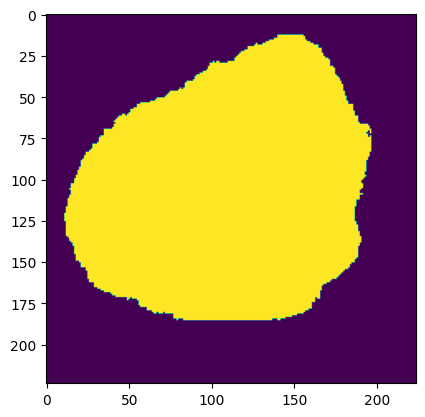

In [36]:
plt.imshow(np.transpose(mask.round().numpy(), (1, 2, 0)))

In [37]:
for item in [255.0, 254.0, 253.0, 252.0]:
    mask[mask == item] = 1.0

In [38]:
torch.nn.functional.sigmoid(res).unique()

tensor([0.5000, 0.7311], device='cuda:0', grad_fn=<Unique2Backward0>)

In [39]:
mask.shape, res.shape

(torch.Size([1, 224, 224]), torch.Size([224, 224]))

In [40]:
accuracy(res.detach().cpu().round(), mask.round().squeeze(0))

tensor(0.9374)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


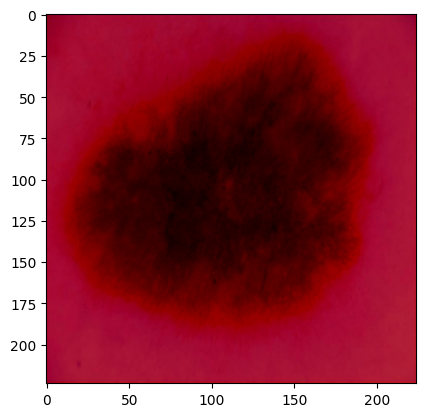

In [285]:
tr = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize([5, 200, 200], [1, 1, 1]),
#     transforms.ColorJitter(hue=.5, brightness=4.)
])
image1 = read_image("test.jpg")
image1 = image1[:3, :, :].float()
image1 = tr(image1)
plt.imshow(np.transpose(image1.long().numpy(), (1,2,0)))

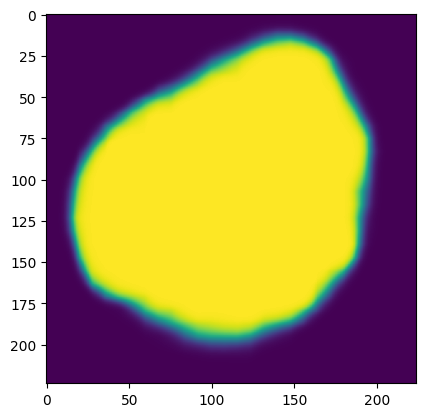

In [275]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


plt.imshow(res.detach().cpu().numpy())